In [2]:
%cd ~/work/deeplearning/

/home/asaeed9/work/deeplearning


In [3]:
from theano.sandbox import cuda
cuda.use('gpu1')
%matplotlib inline
from __future__ import print_function, division
#path="../data/2cat/sample"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink
from keras.preprocessing import image, sequence
import os, sys, cv2
from shutil import copyfile, move
from random import shuffle

####
from keras.layers.convolutional import *
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
import datetime

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5110)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using Theano backend.


In [4]:
data_dir="/home/asaeed9/work/data/2cat"
path="/home/asaeed9/work/data/2cat/sample/"
results_path = "/home/asaeed9/work/data/2cat/sample/results"
test_path = path + '/test/' #We use all the test data
global last_file_timestamp
%cd ../data/2cat/train

/home/asaeed9/work/data/2cat/train


In [5]:
def adjust_prev_data_sample():
    %mv $path/train/cats/* $data_dir/train/
    %mv $path/train/dogs/* $data_dir/train/
    %mv $path/valid/cats/* $data_dir/train/
    %mv $path/valid/dogs/* $data_dir/train/
    
#clean previous data
def adjust_prev_data():
    %mv $data_dir/valid/* $data_dir/train/    
    adjust_prev_data_sample()

def move_data(images, kind, clean):
    
    if clean:
        %mv $path/$kind/cats/* $data_dir/train/
        %mv $path/$kind/dogs/* $data_dir/train/
        
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(images): os.rename(shuf[i], '../sample/'+ kind + '/' + shuf[i]) 
    %mv ../sample/$kind/cat*.jpg ../sample/$kind/cats/
    %mv ../sample/$kind/dog*.jpg ../sample/$kind/dogs/      

# def move_to_unlabel(images):
#     g = glob('*.jpg')
#     shuf = np.random.permutation(g)
#     for i in range(images): os.rename(shuf[i], '../sample/unlabel/' + shuf[i]) 
#     %mv ../sample/unlabel/cat*.jpg ../sample/unlabel/cats/
#     %mv ../sample/unlabel/dog*.jpg ../sample/unlabel/dogs/      
    
    
def handle_null(train, validation):
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(train): copyfile(shuf[i], '../sample/train/' + shuf[i]) 
    %mv ../sample/train/cat*.jpg ../sample/train/cats/
    %mv ../sample/train/dog*.jpg ../sample/train/dogs/
    
    %cd ../valid

    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(validation): copyfile(shuf[i], '../sample/valid/' + shuf[i]) 
    %mv ../sample/valid/cat*.jpg ../sample/valid/cats/
    %mv ../sample/valid/dog*.jpg ../sample/valid/dogs/
    %cd $data_dir/train
    
#copy training images
def copy_samples(train, validation):
    #print("Copying new samples for training...")
    #clean previous data
    adjust_prev_data()
    
    #build validation set
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(validation): os.rename(shuf[i], '../valid/' + shuf[i]) 
    
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(train): copyfile(shuf[i], '../sample/train/' + shuf[i]) 
    %mv ../sample/train/cat*.jpg ../sample/train/cats/
    %mv ../sample/train/dog*.jpg ../sample/train/dogs/
    
    %cd ../valid

    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(validation): copyfile(shuf[i], '../sample/valid/' + shuf[i]) 
    %mv ../sample/valid/cat*.jpg ../sample/valid/cats/
    %mv ../sample/valid/dog*.jpg ../sample/valid/dogs/
    %cd $data_dir/train

def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

def pred_batch(imgs, classes):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[:5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))


def generate_size_graph(fig_no, training_size, accuracy, loss, start_size, end_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(training_size,accuracy)
    plt.plot(training_size,loss)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy/Loss')
    plt.title('Training Size vs Accuracy/Loss')
    plt.grid(True)
    plt.legend(['Accuracy','Loss'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(path + '/batch_graphs/' +  str(start_size) + '_' + str(end_size) + '.jpg') 
        
def generate_graph(fig_no, epochs, train, val, label, train_title, val_title, train_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(epochs,train)
    plt.plot(epochs,val)
    plt.xlabel('num of Epochs')
    plt.ylabel(label)
    plt.title(train_title + ' vs ' + val_title + '( Samples:' + str(train_size) + ')')
    plt.grid(True)
    plt.legend(['train','val'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(results_path + '/batch_graphs/' +  label + '_' + str(train_size) + '.jpg') 
    
def get_train_model(tr_batches, val_batches, epoch):
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3, 256,256)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Dropout(0.2),
#             Convolution2D(64,3,3, activation='relu'),
#             BatchNormalization(axis=1),
            #MaxPooling2D((3,3)),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Dropout(0.2),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Dropout(0.2),
            Flatten(),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(2, activation='softmax')
        ])

    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    model.optimizer.lr = 0.001
    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=epoch - 2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    return model 

def train_model(model, tr_batches, val_batches, epoch):
    if not model:
        model = Sequential([
                BatchNormalization(axis=1, input_shape=(3, 256,256)),
                Convolution2D(32,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
                Dropout(0.2),
    #             Convolution2D(64,3,3, activation='relu'),
    #             BatchNormalization(axis=1),
                #MaxPooling2D((3,3)),
                Convolution2D(64,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
                Dropout(0.2),
                Convolution2D(32,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
                Dropout(0.2),
                Flatten(),
                Dense(1024, activation='relu'),
                BatchNormalization(),
                Dropout(0.2),
                Dense(2, activation='softmax')
            ])
        model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
       
    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    
    model.optimizer.lr = 0.1
    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=1, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    
    model.optimizer.lr = 0.001
    model.fit_generator(tr_batches, tr_batches.nb_sample, nb_epoch=epoch - 3, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
        
    return model 
    
    
def get_test_model():
    model = Sequential([
                BatchNormalization(axis=1, input_shape=(3,256,256)),
                Convolution2D(32,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
    #             Convolution2D(64,3,3, activation='relu'),
    #             BatchNormalization(axis=1),
                #MaxPooling2D((3,3)),
                Convolution2D(64,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
                Convolution2D(32,3,3, activation='relu'),
                BatchNormalization(axis=1),
                MaxPooling2D((3,3)),
                Flatten(),
                Dense(1024, activation='relu'),
                BatchNormalization(),
                Dense(2, activation='softmax')
            ])

    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])  
    
    return model

def fit(samples_copied, old_model, path, results_path, nepoch, batch_size, train_size, valid_size):
    gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)

    #for train in training_range:
    model = None
    if not samples_copied:
        copy_samples(train_size, valid_size)

    tr_batches = gen_t.flow_from_directory(path + 'train', batch_size=batch_size)
    val_batches = gen_t.flow_from_directory(path + 'valid', class_mode='categorical', shuffle=True, batch_size=batch_size * 2)
    
    if old_model:
        model = train_model(old_model, tr_batches, val_batches, nepoch)
    else:
        model = train_model(None, tr_batches, val_batches, nepoch)
        
    #model.save_weights(results_path+ '/' + 'ft_' + str(train_size) + '.e' + str(nepoch))
    last_file_timestamp = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())
    #print('File Time Stamp:{}'.format(last_file_timestamp))
    model.save_weights(results_path+'/ft_{}'.format(last_file_timestamp))
    #model.load_weights(results_path+'/ft_{}'.format(last_file_timestamp))
                          
    return model, last_file_timestamp

def predict(path, model, predict_type):
    gen_test = image.ImageDataGenerator()
    test_batches = gen_test.flow_from_directory(path+predict_type, class_mode=None, target_size=(256,256), shuffle=False, batch_size=1)
    test_data = np.concatenate([test_batches.next() for i in range(test_batches.nb_sample)])
    test_labels = onehot(test_batches.classes)
    score = model.evaluate(test_data, test_labels)
    
    probs = model.predict(test_data)
    
    #loss_score.append(score[0])
    #accuracy_score.append(score[1])
    
    #print("\nLoss:{}, Accuracy:{}".format(score[0], score[1]))
    #print("\nProbabilities:{}".format(probs))
    return probs, test_batches, score[0], score[1]

def move_samples(retrain_set,dest_path, n, limit):
    cats_copied = 0
    dogs_copied = 0
    retrain_list = list(retrain_set)
    shuffle(retrain_list)
    for fil in range(n):
        fil = retrain_list.pop()
        fil_cpy = fil[fil.find('/')+1:]

        if 'cat' in fil_cpy and cats_copied <= limit:
            os.rename(os.path.join(path + "unlabel/cats/"+ fil_cpy), os.path.join(path + dest_path + "/cats/"+ fil_cpy))
            cats_copied+=1
        elif 'dog' in fil_cpy and dogs_copied <= limit:
            os.rename(os.path.join(path + "unlabel/dogs/"+ fil_cpy), os.path.join(path + dest_path + "/dogs/" + fil_cpy))
            dogs_copied+=1
            
    #print("Limit:", limit)        
    #print("moved cats:", cats_copied)
    #print("moved dogs:", dogs_copied)
    #print("Retrain Length: ", len(retrain_list))
    return retrain_list, cats_copied, dogs_copied


def move_to_train(retrain_set, limit):
    cats = 0
    dogs = 0
    valid_limit = int(math.floor(.2*(limit*2)))
    train_limit = int(math.floor(.8*(limit*2)))
    
    #print(retrain_set[:10])
    print("validation set: ", valid_limit)
    retrain_list, cats_copied, dogs_copied = move_samples(retrain_set, "valid", valid_limit, limit)
    valid_size = cats_copied + dogs_copied
    print("Train set: ", train_limit)
    retrain_list, cats_copied, dogs_copied = move_samples(retrain_list, "train", train_limit, limit)
    train_size = cats_copied + dogs_copied
    
    return train_size, valid_size, train_size + valid_size

def refil_unlabel(nimages):
    os.chdir("/home/asaeed9/work/data/2cat/train")
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(nimages): os.rename(shuf[i], '../sample/unlabel/' + shuf[i])
    #os.chdir("../sample/test/")
    #move("cat*.jpg")
    %mv ../sample/unlabel/cat*.jpg ../sample/unlabel/cats/
    %mv ../sample/unlabel/dog*.jpg ../sample/unlabel/dogs/     

In [ ]:
move_data(2000, 'test', True)
move_data(2000, 'unlabel', True)

In [ ]:
%cd $data_dir/train

nepoch = 40
batch_size = 64
train_size = 100
running_train_size = 100
retrain_size = 1800
training_set_size = []
valid_size = int(math.floor(.2 * train_size))
#print('sample size: {}'.format(train_size + valid_size))
tr_model = None
loss = 0.0
loss_array = []
accuracy = 0.0
accuracy_array = []

#copy test data
#move_data(2000, 'test', True)
#move_data(2000, 'unlabel', True)

i=0
for i in range(200):
    print("Train Size:{}".format(train_size))
    print("Valid Size:{}".format(valid_size))

    if train_size == 0 or valid_size == 0: #handle null case
        handle_null(50,10)
        train_size += 50
        valid_size += 10

    tr_model,file_timestamp = fit(i, tr_model, path, results_path, nepoch, batch_size, train_size, valid_size)

    model = None
    model = get_test_model() 
    #model.load_weights(results_path+'/ft_' + str(train_size) + '.e' + str(nepoch))
    #print('{0}/ft_{1}'.format(last_file_timestamp))
    #print('Last File Timestamp- before loading:{}'.format(file_timestamp))
    model.load_weights(results_path+'/ft_{}'.format(file_timestamp))

    print("\nVerification on Unlabel set.")
    probs, test_batches,loss, accuracy = predict(path, model, "unlabel")
    print('\nUnlabel Accuracy:{}'.format(accuracy))
    print('Unlabel Loss:{}'.format(loss))    
#     training_set_size.append(running_train_size)
#     loss_array.append(loss)
#     accuracy_array.append(accuracy)

    #get the top 100, most confused images
    retrain_idx = np.argsort(probs[:,0] - probs[:, 1])[:retrain_size]
    #print(len(retrain_idx))

    retrain_set = [test_batches.filenames[i] for i in retrain_idx]

    #print('Retrain Set Length:{}'.format(len(retrain_set)))

    os.chdir(path + 'unlabel')
    ndog = sum('dog' in name for name in retrain_set)
    ncat =  sum('cat' in name for name in retrain_set)
    limit = min(ncat, ndog)

    #print('Dogs:{}, Cats:{}'.format(ndog, ncat))

    #move existing training data to the store
    #adjust_prev_data_sample()
    train_size, valid_size, copied_images = move_to_train(retrain_set, limit)
    refil_unlabel(copied_images)
    

    print("\nVerification on Test set.")
    model_test = None
    model_test = get_test_model() 
    #model.load_weights(results_path+'/ft_' + str(train_size) + '.e' + str(nepoch))
    #print('{0}/ft_{1}'.format(last_file_timestamp))
    #print('Last File Timestamp- before loading:{}'.format(file_timestamp))
    model_test.load_weights(results_path+'/ft_{}'.format(file_timestamp))

    probs, test_batches,loss, accuracy = predict(path, model_test, "test")
    training_set_size.append(running_train_size)
    loss_array.append(loss)
    accuracy_array.append(accuracy)

    running_train_size += train_size

    print('\nTraining Set Size:{}'.format(training_set_size))
    print('Accuracy:{}'.format(accuracy_array))
    print('Loss:{}'.format(loss_array))
        

/home/asaeed9/work/data/2cat/train
Train Size:100
Valid Size:20
/home/asaeed9/work/data/2cat/valid
/home/asaeed9/work/data/2cat/train
Found 100 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Epoch 1/2
100/100 [==============================] - 2s - loss: 1.0509 - acc: 0.5200 - val_loss: 0.9611 - val_acc: 0.4000
Epoch 2/2
100/100 [==============================] - 1s - loss: 1.1760 - acc: 0.4700 - val_loss: 0.9166 - val_acc: 0.4000
Epoch 1/1
100/100 [==============================] - 2s - loss: 0.9314 - acc: 0.5700 - val_loss: 0.8550 - val_acc: 0.3000
Epoch 1/37
100/100 [==============================] - 2s - loss: 0.7350 - acc: 0.6600 - val_loss: 0.7711 - val_acc: 0.3500
Epoch 2/37
100/100 [==============================] - 1s - loss: 0.9549 - acc: 0.5800 - val_loss: 0.8371 - val_acc: 0.3000
Epoch 3/37
100/100 [==============================] - 1s - loss: 0.9871 - acc: 0.5800 - val_loss: 0.8167 - val_acc: 0.3000
Epoch 4/37
100/100 [==============================

In [ ]:
sample_probs = probs[:3, :]

np.argsort(sample_probs)

In [ ]:
sample_probs

In [ ]:
sample_probs[:3,0] - sample_probs[:3, 1]

In [ ]:
np.argsort(sample_probs[:3,0] - sample_probs[:3, 1])[:2]

In [ ]:
sorted(probs[:2,0] - probs[:2,1])

In [ ]:

np.where(sorted(abs(probs[:2,0] - probs[:2,1])))[0]

#np.where(np.logical_and(probs >=0.4, probs<=0.7))[0]
#np.where()[10]

In [ ]:
np.where(abs(probs[:,0] - probs[:, 1]))[0]

In [6]:
training_set_size = [100, 1504, 2928, 4302, 5722, 7126, 8558, 9966, 11394, 12827, 14204, 15618, 17045, 18427, 19863, 21275, 22699, 24115, 25548, 26916]
accuracy_array = [0.50649999999999995, 0.62, 0.67300000000000004, 0.73750000000000004, 0.77200000000000002, 0.79449999999999998, 0.8145, 0.82750000000000001, 0.85099999999999998, 0.85550000000000004, 0.85650000000000004, 0.86550000000000005, 0.876, 0.89049999999999996, 0.88549999999999995, 0.89349999999999996, 0.90249999999999997, 0.89800000000000002, 0.91100000000000003, 0.92000000000000004]
loss_array = [1.5634963861703872, 1.3101546764373779, 1.3389599814414979, 0.9770810330510139, 0.90527572575211523, 0.77679392026364802, 0.70273019789159297, 0.66951325211301449, 0.53929746384918686, 0.47854575932025911, 0.48957985889911654, 0.40410763838887215, 0.37995399814844133, 0.34014862793684003, 0.38376239252462985, 0.33013378190994264, 0.33610362323373555, 0.31462397079169752, 0.29526432225108146, 0.28285194587707518]

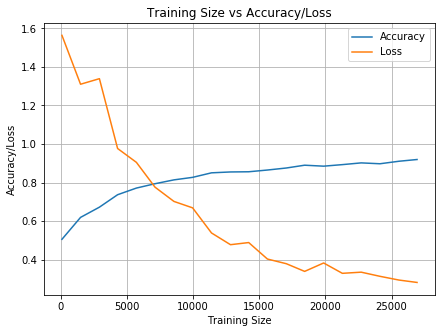

In [7]:
generate_size_graph(1, training_set_size, accuracy_array, loss_array, min(training_set_size), max(training_set_size))